In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from theano import shared
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from Plot_XZ import *
from PCA import *
from scipy.special import gamma
from theano.compile.ops import as_op

np.set_printoptions(precision=0, suppress=True)

In [4]:
Savefig = 0 # 控制图形显示存储

elec_data = pd.read_csv('XZmulti_6.csv')

# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同
# elec_count = elec_data.counts.values

# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 2, size=[len(elec_data.Year.values), 4])

# #特征因素分析
elec_tem = elec_data.Tem.values + SNR[:, 0] # 观测温度值x2
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 1]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 2] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 3] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)

elec_Pca = np.vstack((elec_tem1, elec_hPa1, elec_RH1, elec_Lux1)).T   # 特征数据合并为一个数组
# elec_Pca2 = np.vstack((elec_tem, elec_hPa, elec_RH, elec_Lux)).T   # 特征数据合并为一个数组
# np.savetxt('XZ_nomean.csv', elec_Pca2, delimiter = ',')
# =============================================================================================
# # PCA特征降维，减少相关性，有两种方法，一种是自带函数，一种是网上程序，下面注释为网上程序
# x, z= pcaa(elec_Pca);  XX = np.array(x); ZZ = np.array(z)
# 将温度等4个特征降维变成2个特征，贡献率为99%以上，满足信息要求; 转换后的特征经过模型后能否还原
# =============================================================================================
# #白化，使得每个特征具有相同的方差，减少数据相关性，n_components：控制特征量个数
pca = PCA(n_components=2, whiten=True)
pca.fit(elec_Pca)
# 将数据X转换成降维后的数据。当模型训练好后，对于新输入的数据，都可以用transform方法来降维。
elec_Pca1 = pca.transform(elec_Pca)
elec_Pca1 = np.array(elec_Pca1)
elec_Pca_char1 = elec_Pca1[:, 0] # 降维特征1
elec_Pca_char2 = elec_Pca1[:, 1] # 降维特征2

# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 100 * (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
# elec_faults1 = (elec_faults - np.mean(elec_faults)) / np.std(elec_faults)

# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*6:(i+1)*6] for i in np.arange(21)])
elec_year2 = np.array([elec_year[i*6:(i+1)*6] for i in np.arange(21)])
elec_char1 = np.array([elec_Pca_char1[i*6:(i+1)*6] for i in np.arange(21)])
elec_char2 = np.array([elec_Pca_char2[i*6:(i+1)*6] for i in np.arange(21)])
companyABC2 = np.array([companyABC[i*6:(i+1)*6] for i in np.arange(21)])

# 共享变量设置
xs_char1 = shared(np.asarray(elec_char1))
xs_char2 = shared(np.asarray(elec_char2))

ys_faults = shared(np.asarray(elec_faults2))
xs_year = shared(np.asarray(elec_year2))
Num_shared = shared(np.asarray(companyABC2))


shape=companyABC2.shape
# plt.style.use('default')
# plt.hist(elec_faults, range=[0, 5], bins=130, histtype='stepfilled', color='#6495ED')
# plt.axvline(elec_faults.mean(), color='r', ls='--', label='True mean')
# plt.show()
# 画图
# Plot_XZ(elec_year2, elec_faults2, Savefig)


In [5]:
def logit(x):
    return 1/(1+np.exp(-x))
def tlogit(x):
    return 1/(1+tt.exp(-x))
def Phi(x):
    # probit transform
    return 0.5 + 0.5 * pm.math.erf(x/pm.math.sqrt(2))

In [34]:
# 建模，模型1，该模型为unpooling模型，可用于检测因素影响分析

with pm.Model() as model1:
    # define priors
    alpha = pm.HalfCauchy('alpha', 10, testval=.6)

    beta3 = pm.Normal('beta3', 0, 100, shape=companiesABC)
    beta2 = pm.Normal('beta2', 0, 100, shape=companiesABC)
    beta1 = pm.Normal('beta1', 0, 100, shape=companiesABC)
    beta = pm.Normal('beta', 0, 100, shape=companiesABC)
    # u = pm.Normal('u', 0, 0.0001)

    # beta_mu = pm.Deterministic('beta_mu', tt.exp(beta[Num_shared] + beta1[Num_shared] * xs_year + beta2 * xs_char1 + beta3 * xs_char2))
    linerpredi = tt.exp(beta[companyABC] + beta1[companyABC] * elec_year + beta2[companyABC] * elec_Pca_char1 + beta3[companyABC] * elec_Pca_char2)

    # latent model for contamination
    sigma_p = pm.Uniform('sigma_p', lower=0, upper=3)
    mu_p = pm.Normal('mu_p', mu=0, tau=.001)
    probitphi = pm.Normal('probitphi', mu=mu_p, sd=sigma_p, shape=companiesABC, testval=np.ones(companiesABC))
    phii = pm.Deterministic('phii', Phi(probitphi))

    pi_ij = pm.Uniform('pi_ij', lower=0, upper=1, shape=companyABC.shape)

    # Zij:判断条件，theanof.tt_rng()：Get the package-level random number generator or new with specified seed
    zij_ = pm.theanof.tt_rng().uniform(size=companyABC.shape)
    zij = pm.Deterministic('zij', tt.lt(zij_, phii[companyABC]))

    beta_mu = pm.Deterministic('beta_mu', tt.switch(zij, linerpredi, pi_ij))
    # Observed_pred = pm.Weibull("Observed_pred",  alpha=mu, beta=sigma, shape=elec_faults.shape)  # 观测值
    Observed = pm.Weibull("Observed", alpha=alpha, beta=beta_mu, observed=elec_faults)  # 观测值

#     start = pm.find_MAP()
#     step = pm.Slice([zij, zij_])
    # step = pm.NUTS(scaling=cov, is_cov=True)
#     trace = pm.sample(3000, step=[step], init='advi+adapt_diag', tune=1000)

with model1:
    s = shared(pm.floatX(1))
    inference = pm.ADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    inference.fit(n=20000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)
    trace = approx.sample(3000, include_transformed=True)
    elbos1 = -inference.hist

logp = -70.425, ||grad|| = 23.576: 100%|█████████████████████████████████████████████| 25/25 [00:00<00:00, 1186.25it/s]
Assigned NUTS to alpha_log__
Assigned NUTS to sigma_p_interval__
Assigned NUTS to mu_p
  0%|                                                                                 | 3/4000 [00:01<43:17,  1.54it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:429: UserWarning: Chain 0 contains only 0 samples.
  % (self._chain_id, n))
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:431: UserWarning: Step size tuning was enabled throughout the whole trace. You might want to specify the number of tuning steps.
  warnings.warn('Step size tuning was enabled throughout the whole '
D:\Softwares\Python\Python_Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)



In [8]:
chain = trace[2000:]
varnames2 = ['beta', 'beta1', 'beta2', 'beta3']
# pm.traceplot(chain)
# plt.show()

In [46]:
# #=============== 建模，模型2 ===========================================
# start = trace[0]
# start['zij'] = start['zij'].astype(int)
# stds = approx.bij.rmap(approx.std.eval())
# # stds = approx.bij.rmap(approx.params[0].eval())
# cov = model1.dict_to_array(stds) ** 2
with pm.Model() as model2:
    # define priors
    alpha = pm.HalfCauchy('alpha', 10, testval=.6)

    beta3 = pm.Normal('beta3', 0, 100, shape=companiesABC)
    beta2 = pm.Normal('beta2', 0, 100, shape=companiesABC)
    beta1 = pm.Normal('beta1', 0, 100, shape=companiesABC)
    beta = pm.Normal('beta', 0, 100, shape=companiesABC)
    # u = pm.Normal('u', 0, 0.0001)

    # beta_mu = pm.Deterministic('beta_mu', tt.exp(beta[Num_shared] + beta1[Num_shared] * xs_year + beta2 * xs_char1 + beta3 * xs_char2))
    linerpredi = tt.exp(beta[companyABC] + beta1[companyABC] * elec_year + beta2[companyABC] * elec_Pca_char1 + beta3[companyABC] * elec_Pca_char2)

    # latent model for contamination
    sigma_p = pm.Uniform('sigma_p', lower=0, upper=3)
    mu_p = pm.Normal('mu_p', mu=0, tau=.001)
    probitphi = pm.Normal('probitphi', mu=mu_p, sd=sigma_p, shape=companiesABC, testval=np.ones(companiesABC))
    phii = pm.Deterministic('phii', Phi(probitphi))

    pi_ij = pm.Uniform('pi_ij', lower=0, upper=1, shape=companyABC.shape)

    # Zij:判断条件，theanof.tt_rng()：Get the package-level random number generator or new with specified seed
    zij = pm.Bernoulli('zij', p=phii[companyABC], shape=companyABC.shape)
    beta_mu = pm.Deterministic('beta_mu', tt.switch(tt.eq(zij, 0), linerpredi, pi_ij))

    # Observed_pred = pm.Weibull("Observed_pred",  alpha=mu, beta=sigma, shape=elec_faults.shape)  # 观测值
    Observed = pm.Weibull("Observed", alpha=alpha, beta=beta_mu, observed=elec_faults)  # 观测值

    step1 = pm.Slice([pi_ij, phii])
    step = pm.Metropolis([zij])
    
#     step = pm.NUTS(scaling=cov, is_cov=True)
    trace2 = pm.sample(3000, step=[step, step1], init='advi+adapt_diag', tune=1000)
    
# with model2:
#     s = shared(pm.floatX(1))
#     inference = pm.ADVI(cost_part_grad_scale=s)
#     # ADVI has nearly converged
#     inference.fit(n=20000)
#     # It is time to set `s` to zero
#     s.set_value(0)
#     approx = inference.fit(n=10000)
#     trace2 = approx.sample(3000, include_transformed=True)
#     elbos2 = -inference.hist

Assigned NUTS to alpha_log__
Assigned NUTS to beta3
Assigned NUTS to beta2
Assigned NUTS to beta1
Assigned NUTS to beta
Assigned NUTS to sigma_p_interval__
Assigned NUTS to mu_p
100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [09:37<00:00,  6.93it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 314 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



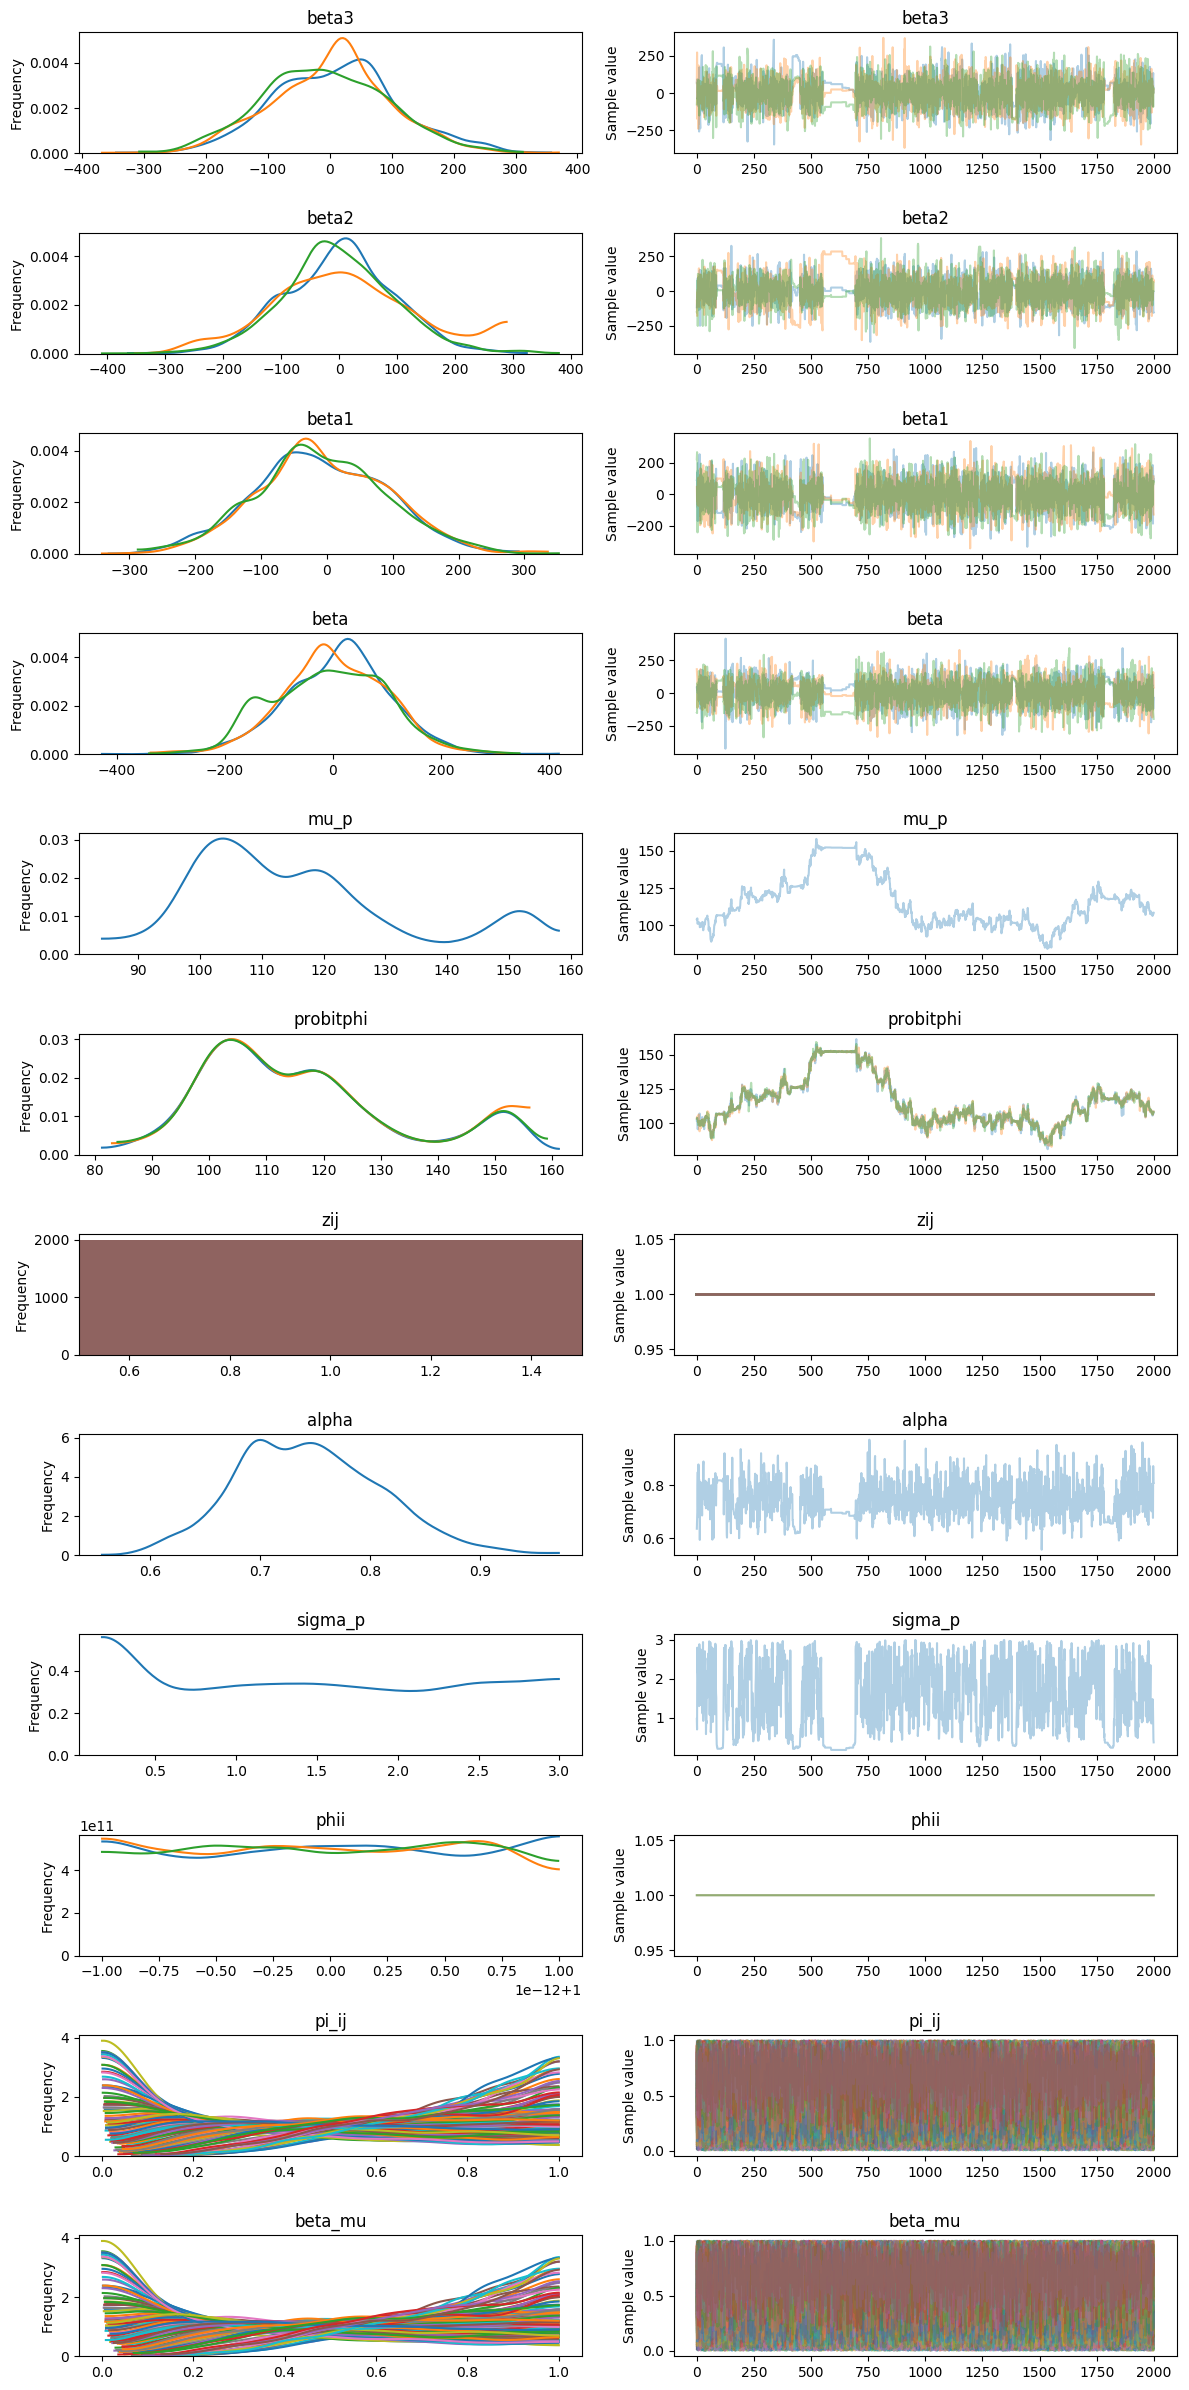

In [47]:
chain2 = trace2[1000:]
varnames2 = ['beta', 'beta1', 'beta2', 'beta3']
# # pm.plot_posterior(chain2, varnames2, ref_val=0)
pm.traceplot(chain2)
plt.show()

D:\Softwares\Python\Python_Anaconda\lib\site-packages\seaborn\categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
D:\Softwares\Python\Python_Anaconda\lib\site-packages\seaborn\categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


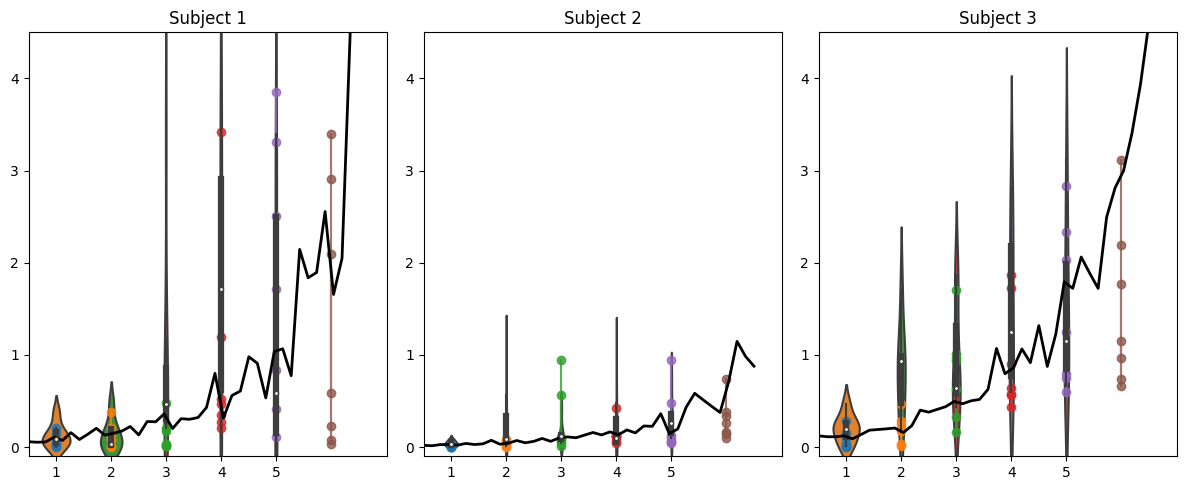

In [39]:
tmp = pm.df_summary(chain2, varnames2)
betaMAP = tmp['mean'][np.arange(companiesABC)]
beta1MAP = tmp['mean'][np.arange(companiesABC) + companiesABC]
beta2MAP = tmp['mean'][np.arange(companiesABC) + 2*companiesABC]
beta3MAP = tmp['mean'][np.arange(companiesABC) + 3*companiesABC]
from matplotlib import gridspec
plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 3)
for ip in np.arange(companiesABC):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip*7:(ip+1)*7, :]   # 原始数据
    yp = elec_faults2[ip*7:(ip+1)*7, :]
    ax.plot(xp, yp, marker='o', alpha=.8)
    
    xl = np.linspace(0.5, 6.5, 40)
    yl = np.exp(betaMAP[ip] + beta1MAP[ip]*xl + beta2MAP[ip]*elec_Pca_char1[ip*42:(ip*42+40)] + beta3MAP[ip]*elec_Pca_char2[ip*42:(ip*42+40)])
    
    ax = sns.violinplot(data=elec_faults2[ip*7:(ip+1)*7])
    plt.plot(xl, yl, 'k', linewidth=2)
    plt.axis([0.5, 7, -.1, 4.5])
    plt.title('Subject %s' % (ip + 1))
plt.tight_layout()
plt.show()

D:\Softwares\Python\Python_Anaconda\lib\site-packages\seaborn\categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
D:\Softwares\Python\Python_Anaconda\lib\site-packages\seaborn\categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


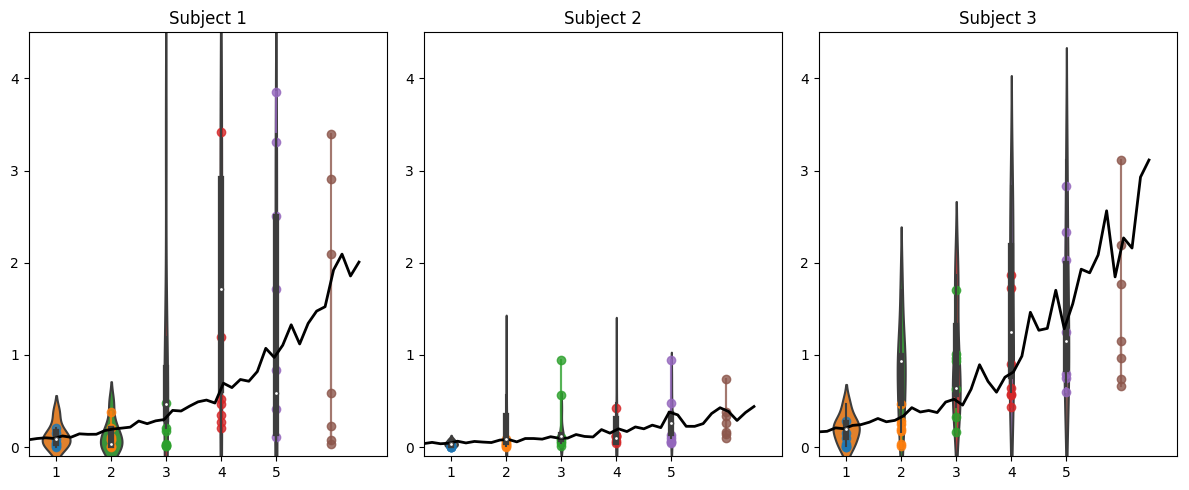

In [40]:
tmp = pm.df_summary(chain, varnames2)
betaMAP = tmp['mean'][np.arange(companiesABC)]
beta1MAP = tmp['mean'][np.arange(companiesABC) + companiesABC]
beta2MAP = tmp['mean'][np.arange(companiesABC) + 2*companiesABC]
beta3MAP = tmp['mean'][np.arange(companiesABC) + 3*companiesABC]
from matplotlib import gridspec
plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 3)
for ip in np.arange(companiesABC):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip*7:(ip+1)*7, :]   # 原始数据
    yp = elec_faults2[ip*7:(ip+1)*7, :]
    ax.plot(xp, yp, marker='o', alpha=.8)
    
    xl = np.linspace(0.5, 6.5, 40)
    yl = np.exp(betaMAP[ip] + beta1MAP[ip]*xl + beta2MAP[ip]*elec_Pca_char1[ip*42:(ip*42+40)] + beta3MAP[ip]*elec_Pca_char2[ip*42:(ip*42+40)])
    
    ax = sns.violinplot(data=elec_faults2[ip*7:(ip+1)*7])
    plt.plot(xl, yl, 'k', linewidth=2)
    plt.axis([0.5, 7, -.1, 4.5])
    plt.title('Subject %s' % (ip + 1))
plt.tight_layout()
plt.show()